Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import json

from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from category_encoders.cat_boost import CatBoostEncoder

from xgboost import XGBRegressor

sklearn.set_config(transform_output = "pandas")

In [35]:
data = pd.read_csv('datasets/predictions/base_predictions.csv')
data.head()

,Age,Brands,Cilinder,Color,Engine,Fuel_type,KM,Location,Models,Price,Transmission,Upholstery,Version,Year,Price_predict
0,1.0,SUZUKI,3.0,rojo,1000.0,gasolina,16684.0,Lima,S-PRESSO,9800.0,mecanica,tela,4x2,2023.0,14889.251
1,1.0,DFSK,4.0,blanco,1500.0,gas_glp,11054.0,Lima,GLORY 500,12000.0,mecanica,tela,delantera,2023.0,14889.251
2,1.0,TOYOTA,4.0,rojo,1300.0,gas_gnv,15500.0,Lima,YARIS,15500.0,mecanica,tela,delantera,2023.0,15833.169
3,4.0,FORD,6.0,blanco,3500.0,gasolina,12500.0,Lima,RAPTOR,75900.0,automatica_secuencial,tela,4x4,2020.0,54109.598
4,1.0,KIA,4.0,gris,1999.0,gasolina,52130.0,Lima,SPORTAGE,27900.0,mecanica,cuero,4x2,2023.0,20570.434


**Find best model**

In [36]:
# joinn all csv files
results = pd.concat([pd.read_csv(f'tuning/{csv_file}') for csv_file in sorted(os.listdir('tuning')) if csv_file.lower().startswith('calibration')], 
                    axis = 0, ignore_index = True)

# filter results according to train > valid & train > test
results = results[(results['opt_train'] <= results['opt_val']) & (results['opt_train'] <= results['opt_test'])].reset_index(drop = True)

# select best iteration
best_iter = results.loc[results['opt_test'].idxmax(), 'iter']

# choose param tuned
param_tuned = results[results['iter'] == best_iter].reset_index(drop = True)

# create overfitting flag
results['valid_overfitting'] = np.where(results['opt_overfitting'] < 0.1, 1, 0)
var_left = results[results['valid_overfitting'] == 1].reset_index(drop = True)
best = var_left.groupby('iter', as_index = False)\
               .agg({'opt_test': ['mean', 'min', 'max', 'std'],
                     'valid_overfitting': ['count'],
                     'opt_overfitting': ['mean']})

best.columns = ['iter', 'mean', 'min', 'max', 'std', 'n_valid', 'opt_overfitting']
best['cv'] = best['std'] / best['mean']
for agg_func in ['mean', 'max', 'opt_overfitting', 'n_valid', 'cv']:
    best[f'{agg_func}_rank'] = pd.qcut(best[agg_func], 10, labels = False, duplicates = 'drop')

best['points'] = best[[col for col in best.columns if 'rank' in col]].sum(axis = 1)
best.sort_values(by = ['points', 'mean'], ascending = [False, False], ignore_index = True, inplace = True)

# get param tuned
param_tuned = var_left[var_left['iter'] == best['iter'].tolist()[0]].reset_index(drop = True)

# get best seed
best_seed = param_tuned.loc[param_tuned['seed'].idxmax(), 'seed']

# get best hyperparameters
best_params = param_tuned[param_tuned['seed'] == best_seed].sort_values(by = ['best_overfitting'], ignore_index = True)

# save record as json file
record = best_params.to_dict('records')[0]
with open('json_files/best_params_cal.json', 'w') as file:
    json.dump(record, file, indent = 4)

best_params.head(1)

,iter,seed,cv_fold,params,n_trees,opt_n_trees,opt_train,opt_val,opt_test,opt_overfitting,best_n_trees,best_train,best_val,best_test,best_overfitting,valid_overfitting
0,87,98,1,"{'alpha': 1, 'gamma': 0.1, 'learning_rate': 0....",16,15,0.696845,0.776726,0.780235,-0.079881,15,0.696845,0.776726,0.780235,-0.079881,1


**Refit model with found hyperparameters**

In [38]:
# get best record
record = best_params.to_dict('records')[0]

# split data into subsets
trainval, test = train_test_split(data, train_size = 0.8, shuffle = True, random_state = record['seed'])

# get X and y matrices
X = trainval[['Price_predict', 'Year']].copy()
y = trainval['Price'].copy()

X_test = test[['Price_predict', 'Year']].copy()
y_test = test['Price'].copy()

# get subsets with kfold
cv = KFold(n_splits = 5, shuffle = True, random_state = record['seed'])

train_index, val_index = list(cv.split(X, y))[0]

# get train and val set
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_val, y_val = X.iloc[val_index], y.iloc[val_index]

In [39]:
# declare calibrator
calibrator = XGBRegressor(objective = 'reg:squarederror',
                          eval_metric = r2_score,
                          n_estimators = record['n_trees'],
                          use_label_encoder = False,
                          monotone_constraints = '(1, 1)',
                          **eval(record['params']))

# fit estimator
calibrator.fit(X = X_train,
               y = y_train,
               eval_set = [(X_train, y_train),
                           (X_val, y_val),
                           (X_test, y_test)],
               verbose = 0)

# save objects
with open(f'objects/calibrator.pkl', 'wb') as file:
    pickle.dump(calibrator, file)

**Reevaluate model**

In [40]:
# get best record
record = best_params.to_dict('records')[0]

# split data into subsets
trainval, test = train_test_split(data, train_size = 0.8, shuffle = True, random_state = record['seed'])

# get X and y matrices
X = trainval.drop(columns = 'Price').copy()
y = trainval['Price'].copy()

X_test = test.drop(columns = 'Price').copy()
y_test = test['Price'].copy()

# get subsets with kfold
cv = KFold(n_splits = 5, shuffle = True, random_state = record['seed'])

train_index, val_index = list(cv.split(X, y))[record['cv_fold']]

# get train and val set
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_val, y_val = X.iloc[val_index], y.iloc[val_index]

In [41]:

with open(f'objects/calibrator.pkl', 'rb') as file:
    calibrator = pickle.load(file)

# merge datasets
data_train = pd.concat([X_train, y_train], axis = 1).assign(sample = 'train')
data_val = pd.concat([X_val, y_val], axis = 1).assign(sample = 'val')
data_test = pd.concat([X_test, y_test], axis = 1).assign(sample = 'test')

data_prep = pd.concat([data_train, data_val, data_test], axis = 0, ignore_index = True)

# create punctuations
data_prep['Price_calibrate'] = calibrator.predict(data_prep[calibrator.get_booster().feature_names])

# get first metrics
summary = data_prep.groupby('sample')\
                   .apply(lambda df: r2_score(df['Price'], df['Price_calibrate']), include_groups = False)\
                   .loc[['train', 'val', 'test']]
summary

sample
train    0.699314
val      0.798668
test     0.785217
dtype: float64

See results

In [42]:
data_prep.describe()

,Age,Cilinder,Engine,KM,Year,Price_predict,Price,Price_calibrate
count,6903.000000,5869.000000,6.402000e+03,6.740000e+03,6903.000000,6904.000000,6904.000000,6904.000000
mean,7.680719,4.315727,4.542234e+03,6.942658e+04,2016.319281,19307.249717,19229.570158,19364.123047
std,6.600145,1.001359,1.202761e+05,1.127016e+05,6.600145,8900.935247,14396.858724,10593.947266
min,0.000000,1.000000,1.000000e+00,1.000000e+01,1927.000000,7579.339400,1.000000,6563.395020
25%,3.000000,4.000000,1.591000e+03,3.000000e+04,2014.000000,13523.563750,11000.000000,12586.275391
50%,6.000000,4.000000,1.998000e+03,5.650000e+04,2018.000000,16987.834000,16000.000000,17048.548828
75%,10.000000,4.000000,2.400000e+03,9.000000e+04,2021.000000,22214.993750,23000.000000,22546.996094
max,97.000000,14.000000,8.816657e+06,7.824000e+06,2024.000000,86579.800000,310000.000000,116419.500000


See important features

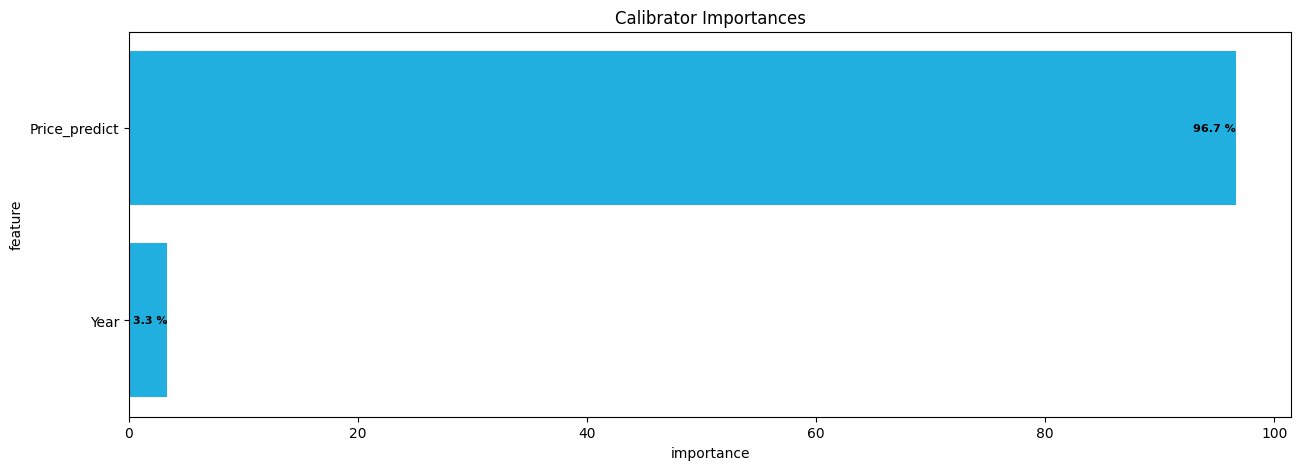

In [48]:
# get feature importances
feature_importances = pd.DataFrame({'feature': calibrator.get_booster().feature_names,
                                    'importance': calibrator.feature_importances_ * 100})\
                        .sort_values(by = 'importance', ascending = False, ignore_index = True)

# plot feature importances
plt.figure(figsize = (15, 5))
sns.barplot(data = feature_importances,
            x = 'importance',
            y = 'feature',
            orient = 'h',
            color = 'deepskyblue',)

for x, y in enumerate(feature_importances['importance'].tolist()):
    plt.text(x = y,
             y = x,
             s = f'{y:.1f} %',
             ha = 'right',
             va = 'center',
             fontdict = dict(weight = 'bold', fontsize = 8))
plt.title('Calibrator Importances')
plt.show()

Save categories

In [81]:
# get object data
data_model = data[calibrator.get_booster().feature_names]

# get columns
columns = data_model.select_dtypes(exclude = np.number).columns.tolist()

# save unique features per column
unique_cat = {feat: data_model[feat].dropna().unique().tolist() for feat in columns}

# save json variable
with open('json_files/unique_cat_values.json', 'w') as file:
    json.dump(unique_cat, file, indent = 4)

get unique model per brand

In [108]:
pddf = pd.read_csv('datasets/clean/data.csv')

brands = pddf.loc[:, ['Brands', 'Models']]\
             .drop_duplicates()\
             .groupby('Brands')\
             .agg({'Models': list})\
             .to_dict()['Models']

# save json file
with open('json_files/brand_model.json', 'w') as file:
    json.dump(brands, file, indent = 4)

## Test case

In [50]:
# read objects
with open(f'objects/encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)

with open(f'objects/transformer.pkl', 'rb') as file:
    transformer = pickle.load(file)

with open(f'objects/preprocessing.pkl', 'rb') as file:
    preprocessing = pickle.load(file)

with open(f'objects/estimator.pkl', 'rb') as file:
    estimator = pickle.load(file)

In [55]:
current_year = 2024
car_age = 2014
age = current_year - car_age
brand = 'SUZUKI'
cilinder = 3
color = 'negro'
engine = 1100
fuel_type = 'gasolina'
km = 40000
location = 'Lima'
model = 'CELERIO'
transmission = 'mecanica'
upholstery = 'tela'
version = 'delantera'

vector = [age, brand, cilinder, color, engine, fuel_type, km, location, model, transmission, upholstery, version]
keys = estimator.get_booster().feature_names
sample = pd.DataFrame(dict(zip(keys, [[v] for v in vector])))

sample = encoder.transform(sample)
sample = transformer.transform(sample)
price = estimator.predict(sample)[0]

vector_cal = [price, car_age]
keys = calibrator.get_booster().feature_names
sample = pd.DataFrame(dict(zip(keys, [[v] for v in vector_cal])))

price_cal = calibrator.predict(sample)[0]
price_cal

12063.438

**Calibration curve**

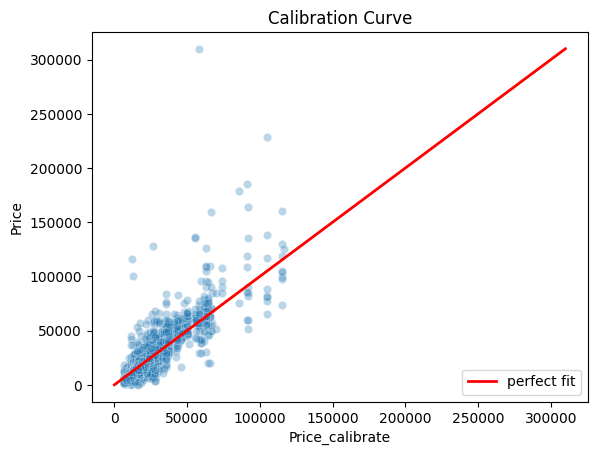

In [58]:
sns.scatterplot(data = data_prep,
                x = 'Price_calibrate',
                y = 'Price',
                alpha = 0.3)

plt.plot([data_prep['Price'].min(), data_prep['Price'].max()], 
         [data_prep['Price'].min(), data_prep['Price'].max()], 
         color = 'red', 
         lw = 2,
         label = 'perfect fit')
plt.title('Calibration Curve')
plt.legend()
plt.show()